# IN Experiment Notebook

## Overview
This notebook demonstrates the complete workflow for the IN (Example Image Benchmark) experiment. The workflow includes the following steps:

1. **Labels Check & Loading:**  
   Verify the existence of `labels.csv` and load or create labels from images in `../data/training_data`.

2. **Define Custom Configurations:**  
   Set up custom Gaussian Noise levels (std) and training epoch configurations.

3. **Model Training & Evaluation:**  
   - **Model Building:** Construct the CNN model using `build_IN_cnn(...)` for each custom slope.
   - **Training:** Train the model with block-based splitting (using the first image in every block of 5 for testing) via `train_model(...)`.
   - **Feature Extraction & Correlation:** Extract intermediate features and compute the pairwise correlation matrix.
   - **Results Saving:** Save the correlation matrices and training/validation metrics (accuracy and loss) as JSON files under `../res/IN/{epoch}/`.

4. **Visualization:**  
   Plot the training/validation curves and the correlation matrix using custom plotting functions.

---


In [1]:
# In[1] : Imports and Path Settings

import sys
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

# If your code is in 'src/preprocessing.py'
from preprocessing import load_dataset
from models import build_cnn, train_model
from analysis import (
    compute_correlations,
    visualize_c, 
    plot_metrics_acc,
    visualized_cor_mat
)
from utils import save_json, convert_to_serializable
from tqdm import tqdm


## 1. Check and (if needed) Create Label CSV
If `../data/labels.csv` is not present, we load images from `../data/training_data/`,
generate the CSV, and store it. Otherwise, we read it and still load images/labels.


In [2]:
# In[2]: Checking/creating label CSV

label_csv_path = '../data/labels.csv'
data_folder = '../data/training_data'   # e.g. ../data/training_data/personA, ../data/training_data/personB, ...
target_size = (128, 128)                # desired image size

if not os.path.exists(label_csv_path):
    print("Label CSV not found. Generating from image folder...")
    df, images_data, labels = load_dataset(data_folder, target_size=target_size)
    df.to_csv(label_csv_path, index=False)
    print(f"Saved new label CSV to {label_csv_path}")
else:
    print("Label CSV found. Reading it now...")
    df = pd.read_csv(label_csv_path)
    print("CSV preview (head):")
    print(df.head())
    # We still need images & labels in memory for training:
    df, images_data, labels = load_dataset(data_folder, target_size=target_size)


dfPerson= pd.read_csv(label_csv_path)
personName = dfPerson.columns[1:].tolist()

print(f"DataFrame shape: {df.shape}")  # Should match labels count
print(f"Image count: {len(images_data)}")  # Should match labels count
print(f"Labels shape: {labels.shape}")  # (N, num_persons)
print(personName)

assert len(images_data) == labels.shape[0], "Mismatch between images and labels!"


Label CSV found. Reading it now...
CSV preview (head):
          img_id  juliana  kim  mai  michael  ntr  park  patrick  pedro  \
0  juliana_0.png        1    0    0        0    0     0        0      0   
1  juliana_1.png        1    0    0        0    0     0        0      0   
2  juliana_2.png        1    0    0        0    0     0        0      0   
3  juliana_3.png        1    0    0        0    0     0        0      0   
4  juliana_4.png        1    0    0        0    0     0        0      0   

   rachel  zen  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
DataFrame shape: (50, 11)
Image count: 50
Labels shape: (50, 10)
['juliana', 'kim', 'mai', 'michael', 'ntr', 'park', 'patrick', 'pedro', 'rachel', 'zen']


## 2. Define Custom Slopes, Epochs, and Iterations

Change or expand these lists as desired. For each STD in `noise_level_list`,
we'll train the model for each number of slope in `ep` with `num` loops.



In [3]:
# In[3]: Custom Slopes & Epochs

custom_slope = 0.05  # Example slopes for custom ReLU
noise_level_list = [0, 0.5, 5] # Example slopes for custom Gaussian noise level in STD
ep = 10      # Example epoch counts
num = 3  # Number of iterations

train_accuracies = {}
train_accuracies_dict = {}
train_losses = {}
train_loss_dict = {}
val_losses = {}
val_losses_dict = {}
val_accuracies = {}
val_accuracies_dict = {}
cor_dict = {}
trained_Model = {}


## 3. Main Training Loop

The following code block implements the main training loop. For each iteration and for each noise level (Gaussian STD) from `noise_level_list`, the loop performs the following steps:

1. **Clears Previous Metrics:**  
Resets dictionaries that store correlation matrices and training/validation metrics.

2. **Data Preparation:**  
   Converts the preprocessed images stored in `images_data` into a NumPy array.

3. **Model Building:**  
   Constructs a CNN model using the `build_cnn` function. The model is built with a extra Gaussian Noise Layer in the end of each Convolutional blocks and the current noise level (`std`).

4. **Model Training:**  
   Trains the model using block-based splitting (the first image in every block of 5 is used for testing) via the `train_model` function.

5. **Metrics Storage:**  
   Stores training and validation accuracy and loss metrics in dictionaries keyed by the noise level.

6. **Results Saving:**  
   Converts the metrics to a JSON-serializable format and saves them as JSON files in the results directory (`../res/IN/{ep}/`).  
   *(Note: The correlation computation section is currently commented out.)*

7. **Metrics Plotting:**  
   Visualizes the training and validation curves for accuracy and loss across different Gaussian STD values.


num_loop:   0%|          | 0/3 [00:00<?, ?it/s]

noise =  0
Epoch 1/10
1/1 [==============================] - 1s 673ms/step - loss: 0.6872 - accuracy: 0.0500 - val_loss: 0.6918 - val_accuracy: 0.1000
Epoch 2/10
1/1 [==============================] - 0s 221ms/step - loss: 0.5906 - accuracy: 0.1000 - val_loss: 0.6900 - val_accuracy: 0.1000
Epoch 3/10
1/1 [==============================] - 0s 225ms/step - loss: 0.5424 - accuracy: 0.1250 - val_loss: 0.6880 - val_accuracy: 0.1000
Epoch 4/10
1/1 [==============================] - 0s 222ms/step - loss: 0.5834 - accuracy: 0.0750 - val_loss: 0.6864 - val_accuracy: 0.1000
Epoch 5/10
1/1 [==============================] - 0s 223ms/step - loss: 0.4855 - accuracy: 0.1750 - val_loss: 0.6847 - val_accuracy: 0.1000
Epoch 6/10
1/1 [==============================] - 0s 216ms/step - loss: 0.4463 - accuracy: 0.2750 - val_loss: 0.6827 - val_accuracy: 0.1000
Epoch 7/10
1/1 [==============================] - 0s 224ms/step - loss: 0.4357 - accuracy: 0.2000 - val_loss: 0.6804 - val_accuracy: 0.1000
Epoch 8/1

num_loop:  33%|███▎      | 1/3 [00:08<00:16,  8.40s/it]

noise =  0
Epoch 1/10
1/1 [==============================] - 1s 674ms/step - loss: 0.7379 - accuracy: 0.0750 - val_loss: 0.6919 - val_accuracy: 0.1000
Epoch 2/10
1/1 [==============================] - 0s 216ms/step - loss: 0.6690 - accuracy: 0.1250 - val_loss: 0.6903 - val_accuracy: 0.1000
Epoch 3/10
1/1 [==============================] - 0s 220ms/step - loss: 0.6224 - accuracy: 0.1000 - val_loss: 0.6886 - val_accuracy: 0.1000
Epoch 4/10
1/1 [==============================] - 0s 217ms/step - loss: 0.5951 - accuracy: 0.0500 - val_loss: 0.6869 - val_accuracy: 0.1000
Epoch 5/10
1/1 [==============================] - 0s 224ms/step - loss: 0.5724 - accuracy: 0.1250 - val_loss: 0.6852 - val_accuracy: 0.1000
Epoch 6/10
1/1 [==============================] - 0s 221ms/step - loss: 0.4981 - accuracy: 0.1500 - val_loss: 0.6832 - val_accuracy: 0.1000
Epoch 7/10
1/1 [==============================] - 0s 220ms/step - loss: 0.5293 - accuracy: 0.2250 - val_loss: 0.6816 - val_accuracy: 0.1000
Epoch 8/1

num_loop:  67%|██████▋   | 2/3 [00:16<00:08,  8.45s/it]

noise =  0
Epoch 1/10
1/1 [==============================] - 1s 669ms/step - loss: 0.7476 - accuracy: 0.0500 - val_loss: 0.6920 - val_accuracy: 0.1000
Epoch 2/10
1/1 [==============================] - 0s 223ms/step - loss: 0.6499 - accuracy: 0.1500 - val_loss: 0.6902 - val_accuracy: 0.1000
Epoch 3/10
1/1 [==============================] - 0s 221ms/step - loss: 0.5695 - accuracy: 0.2750 - val_loss: 0.6884 - val_accuracy: 0.1000
Epoch 4/10
1/1 [==============================] - 0s 227ms/step - loss: 0.5678 - accuracy: 0.2250 - val_loss: 0.6864 - val_accuracy: 0.1000
Epoch 5/10
1/1 [==============================] - 0s 222ms/step - loss: 0.5091 - accuracy: 0.3250 - val_loss: 0.6843 - val_accuracy: 0.1000
Epoch 6/10
1/1 [==============================] - 0s 220ms/step - loss: 0.4732 - accuracy: 0.2000 - val_loss: 0.6824 - val_accuracy: 0.1000
Epoch 7/10
1/1 [==============================] - 0s 225ms/step - loss: 0.4464 - accuracy: 0.2000 - val_loss: 0.6811 - val_accuracy: 0.1000
Epoch 8/1

num_loop: 100%|██████████| 3/3 [00:25<00:00,  8.43s/it]


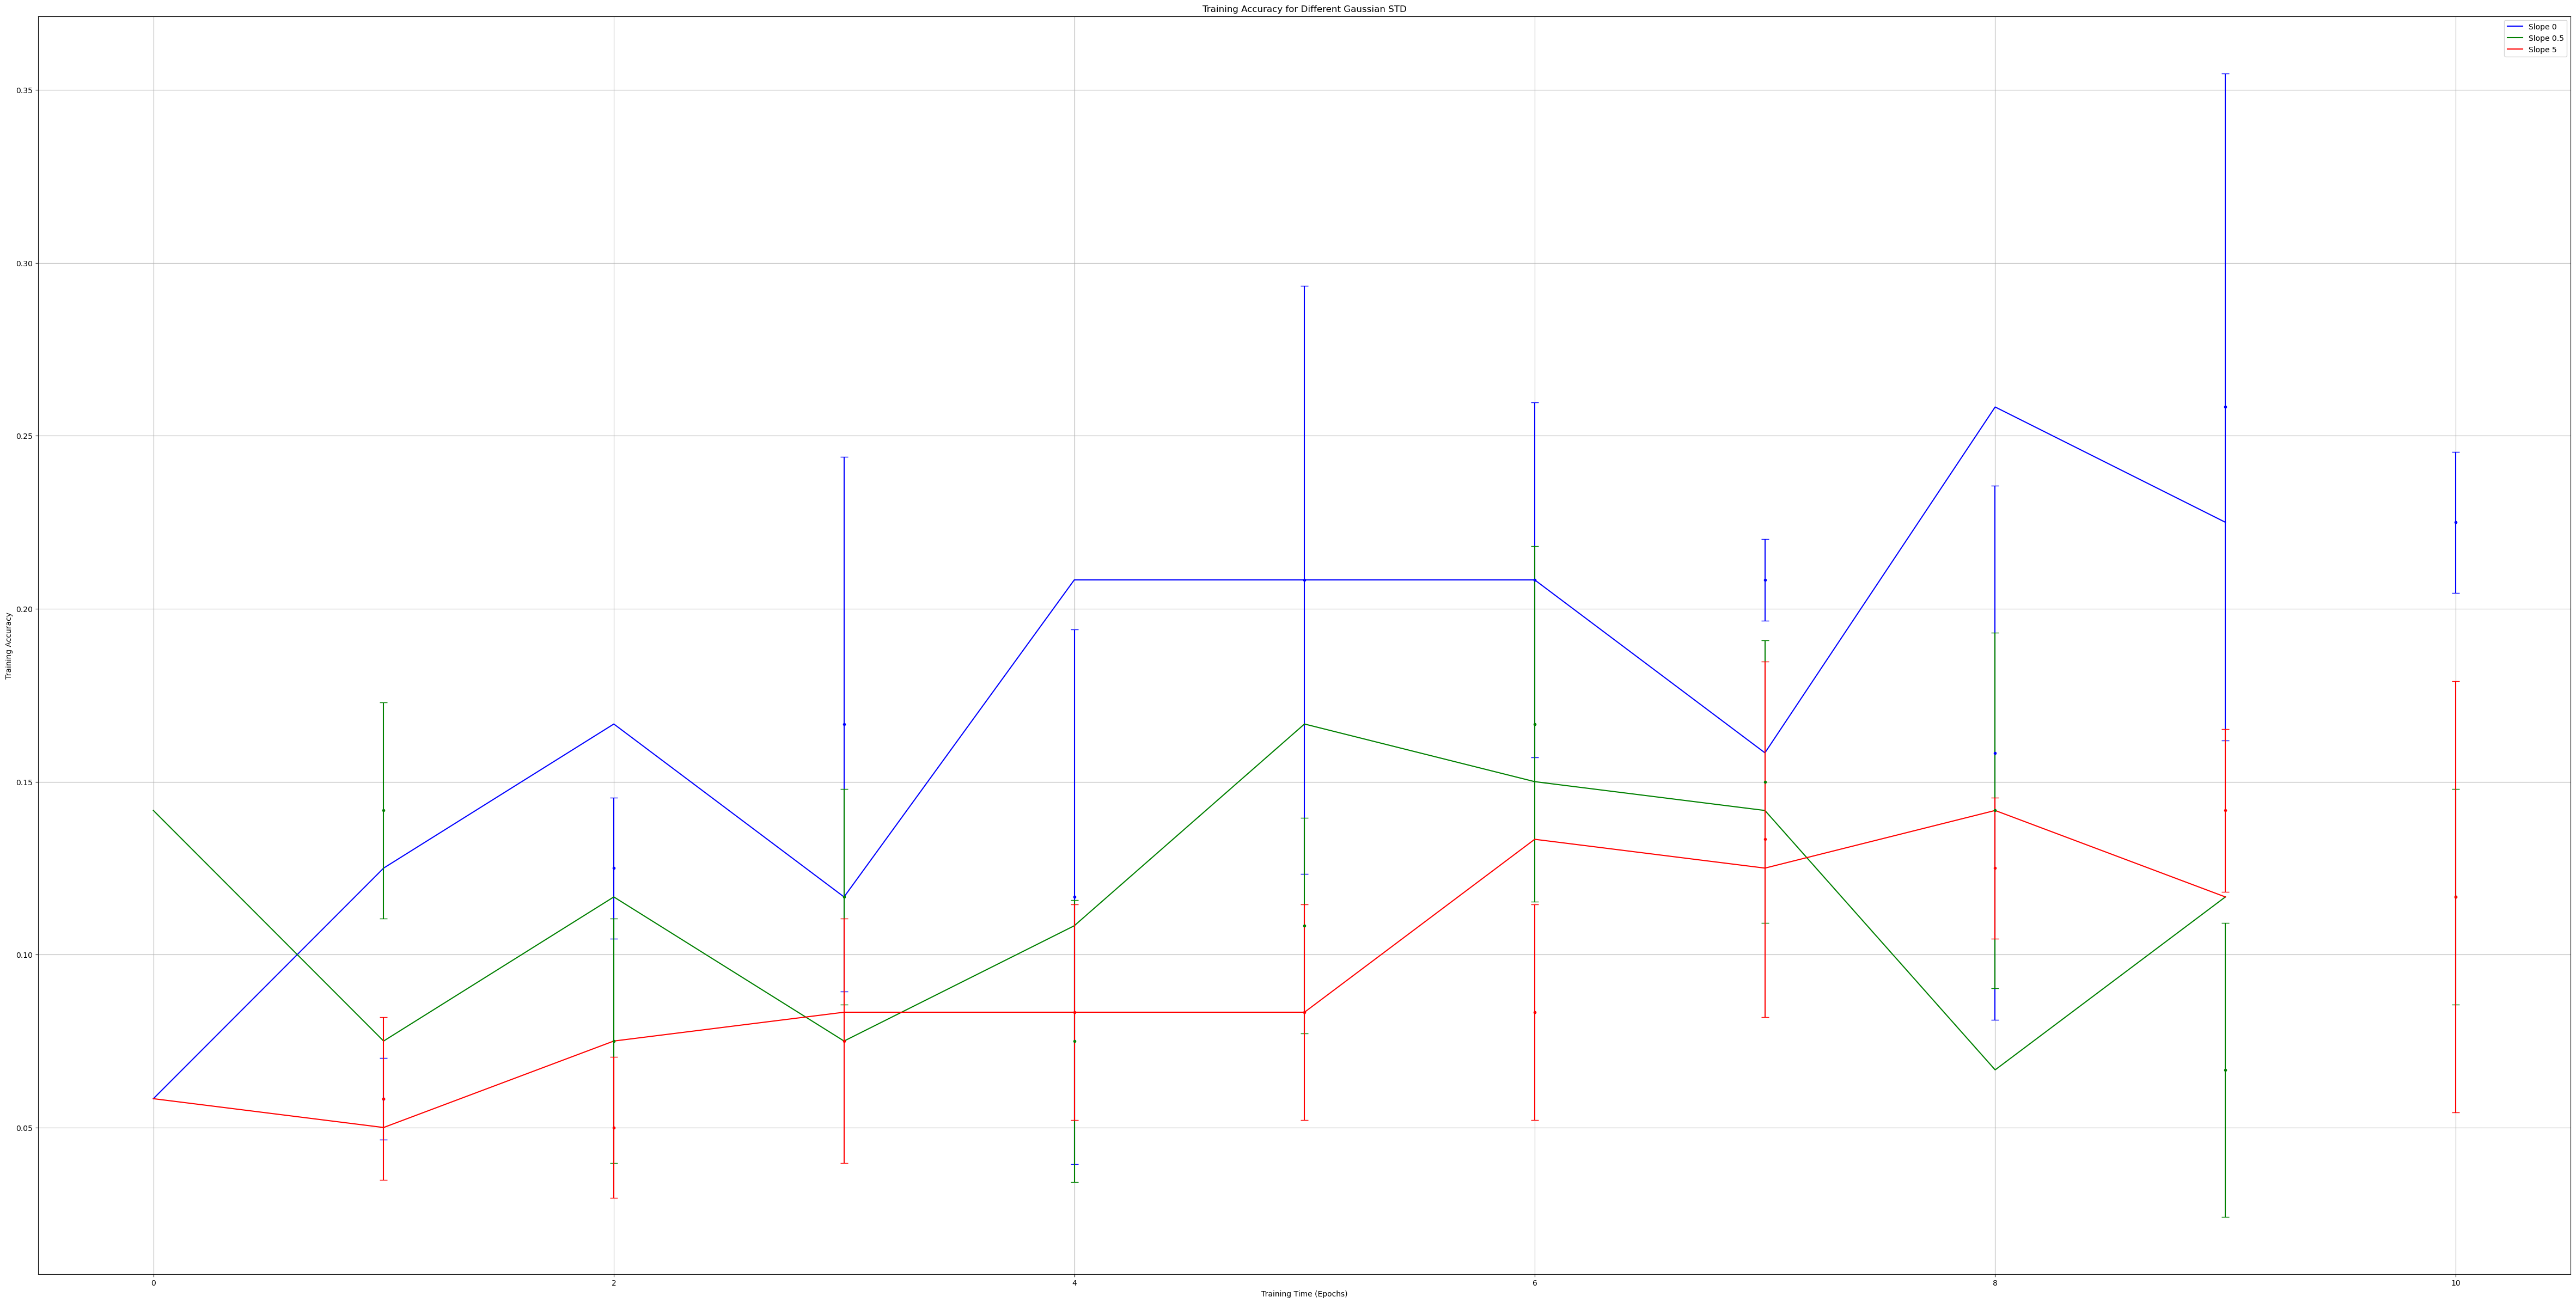

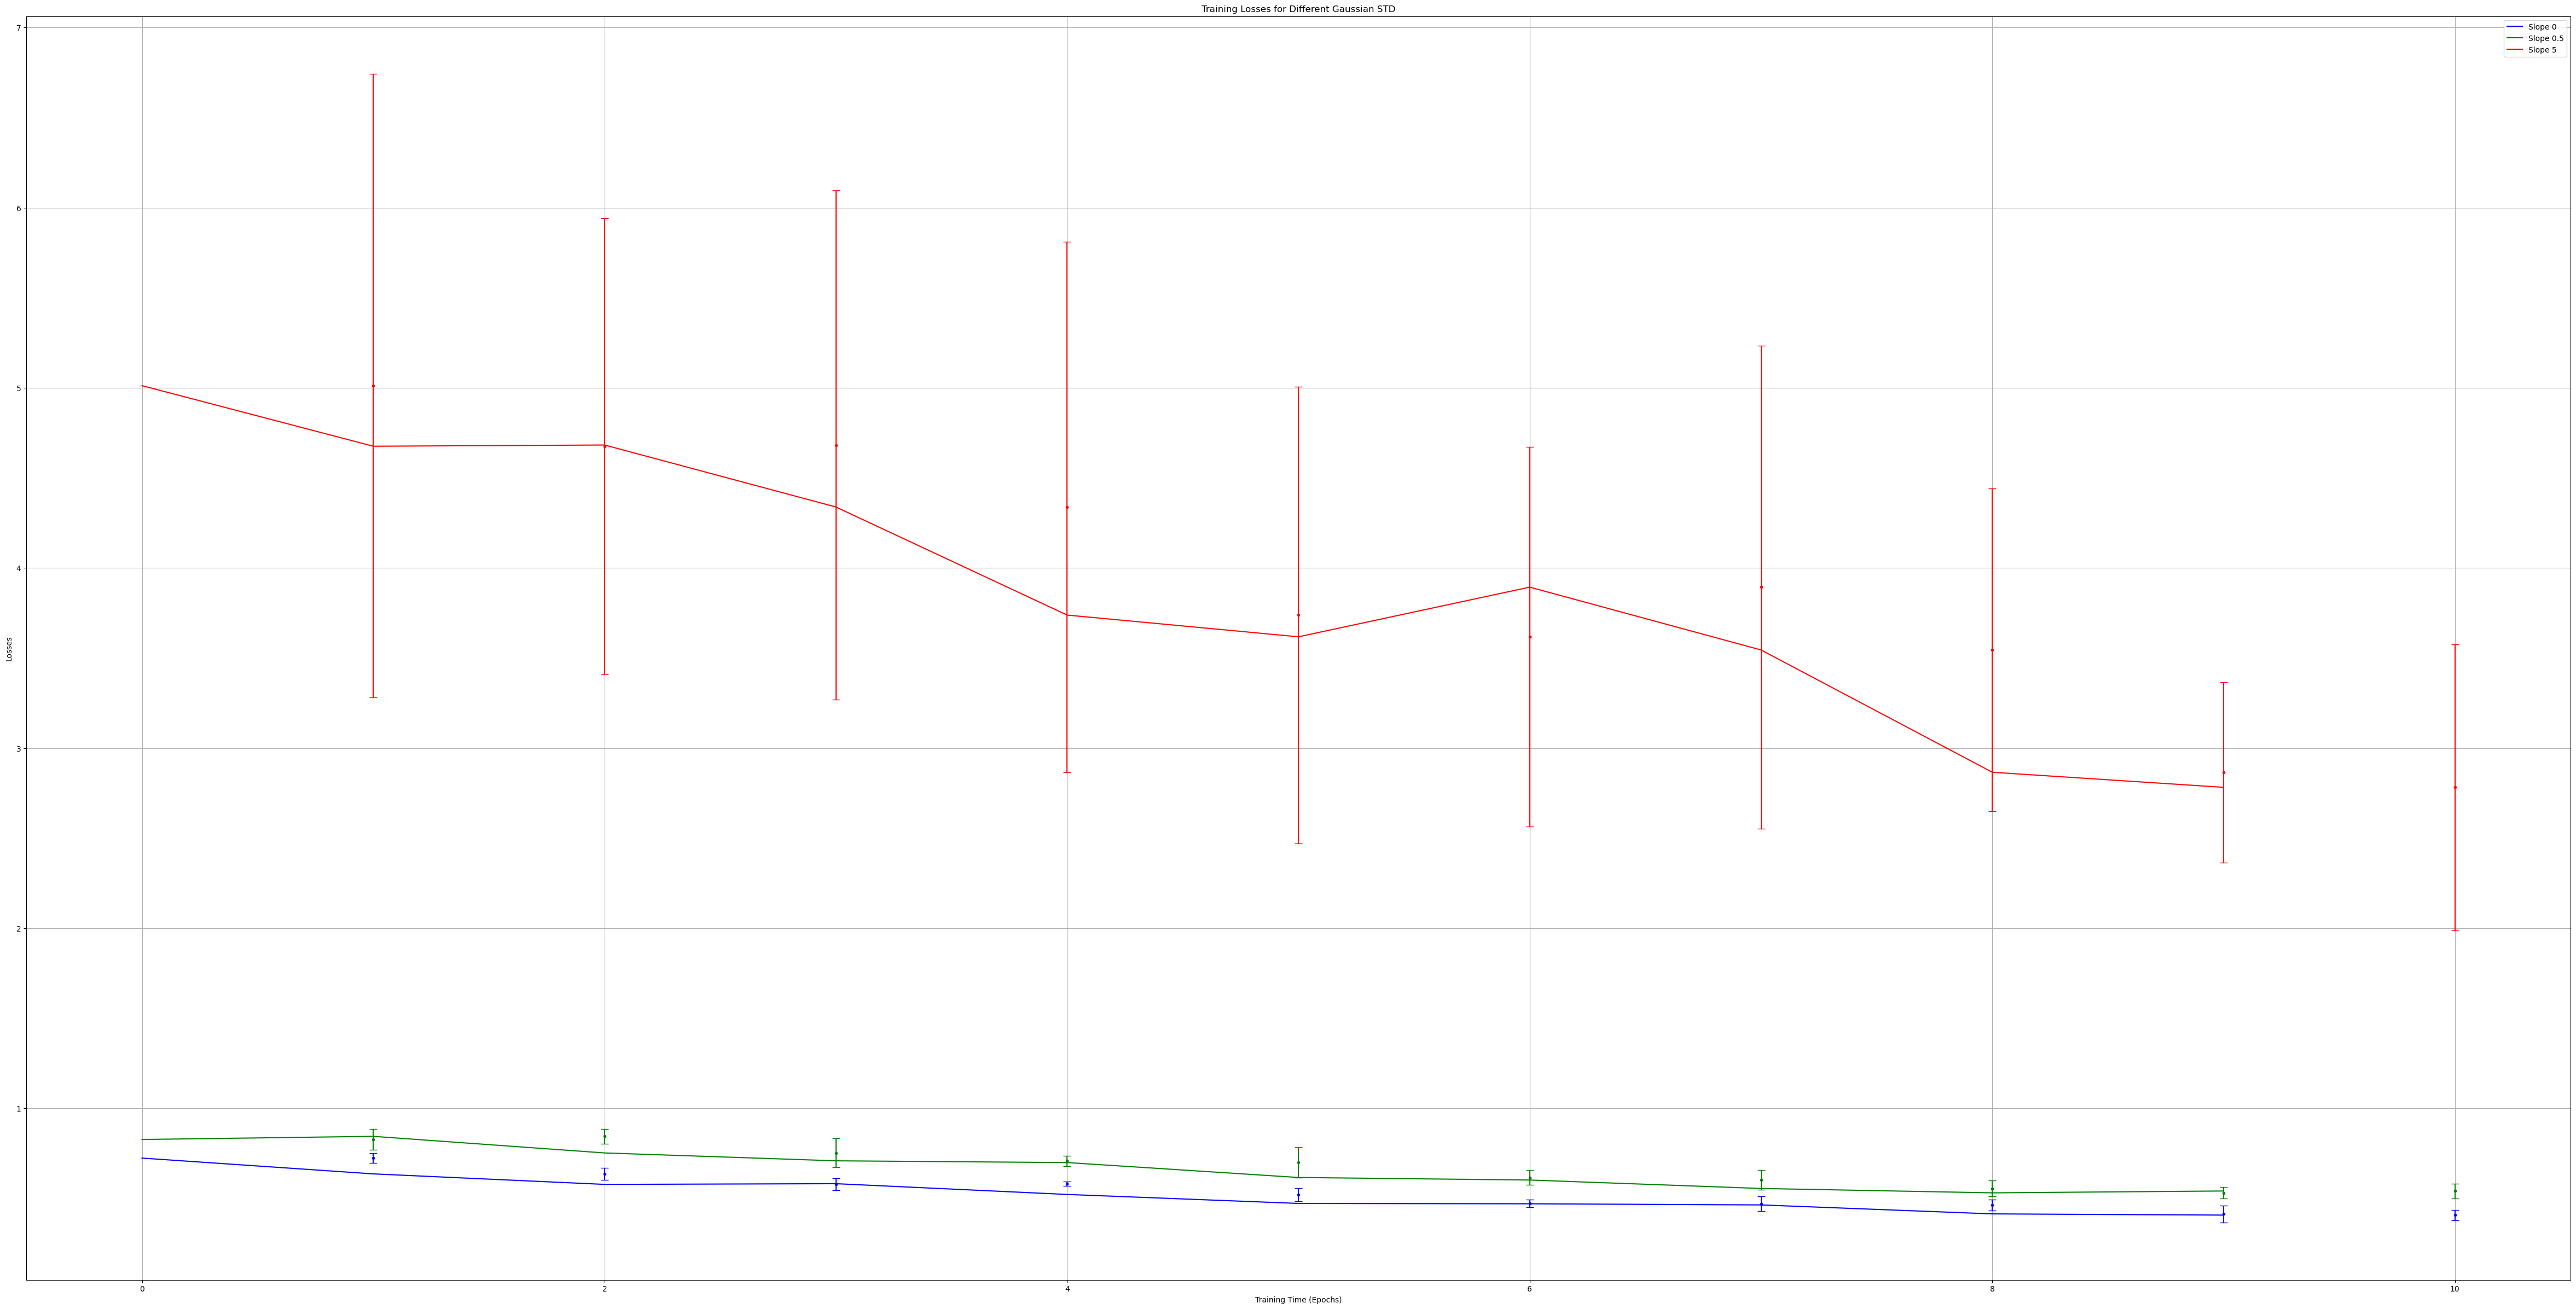

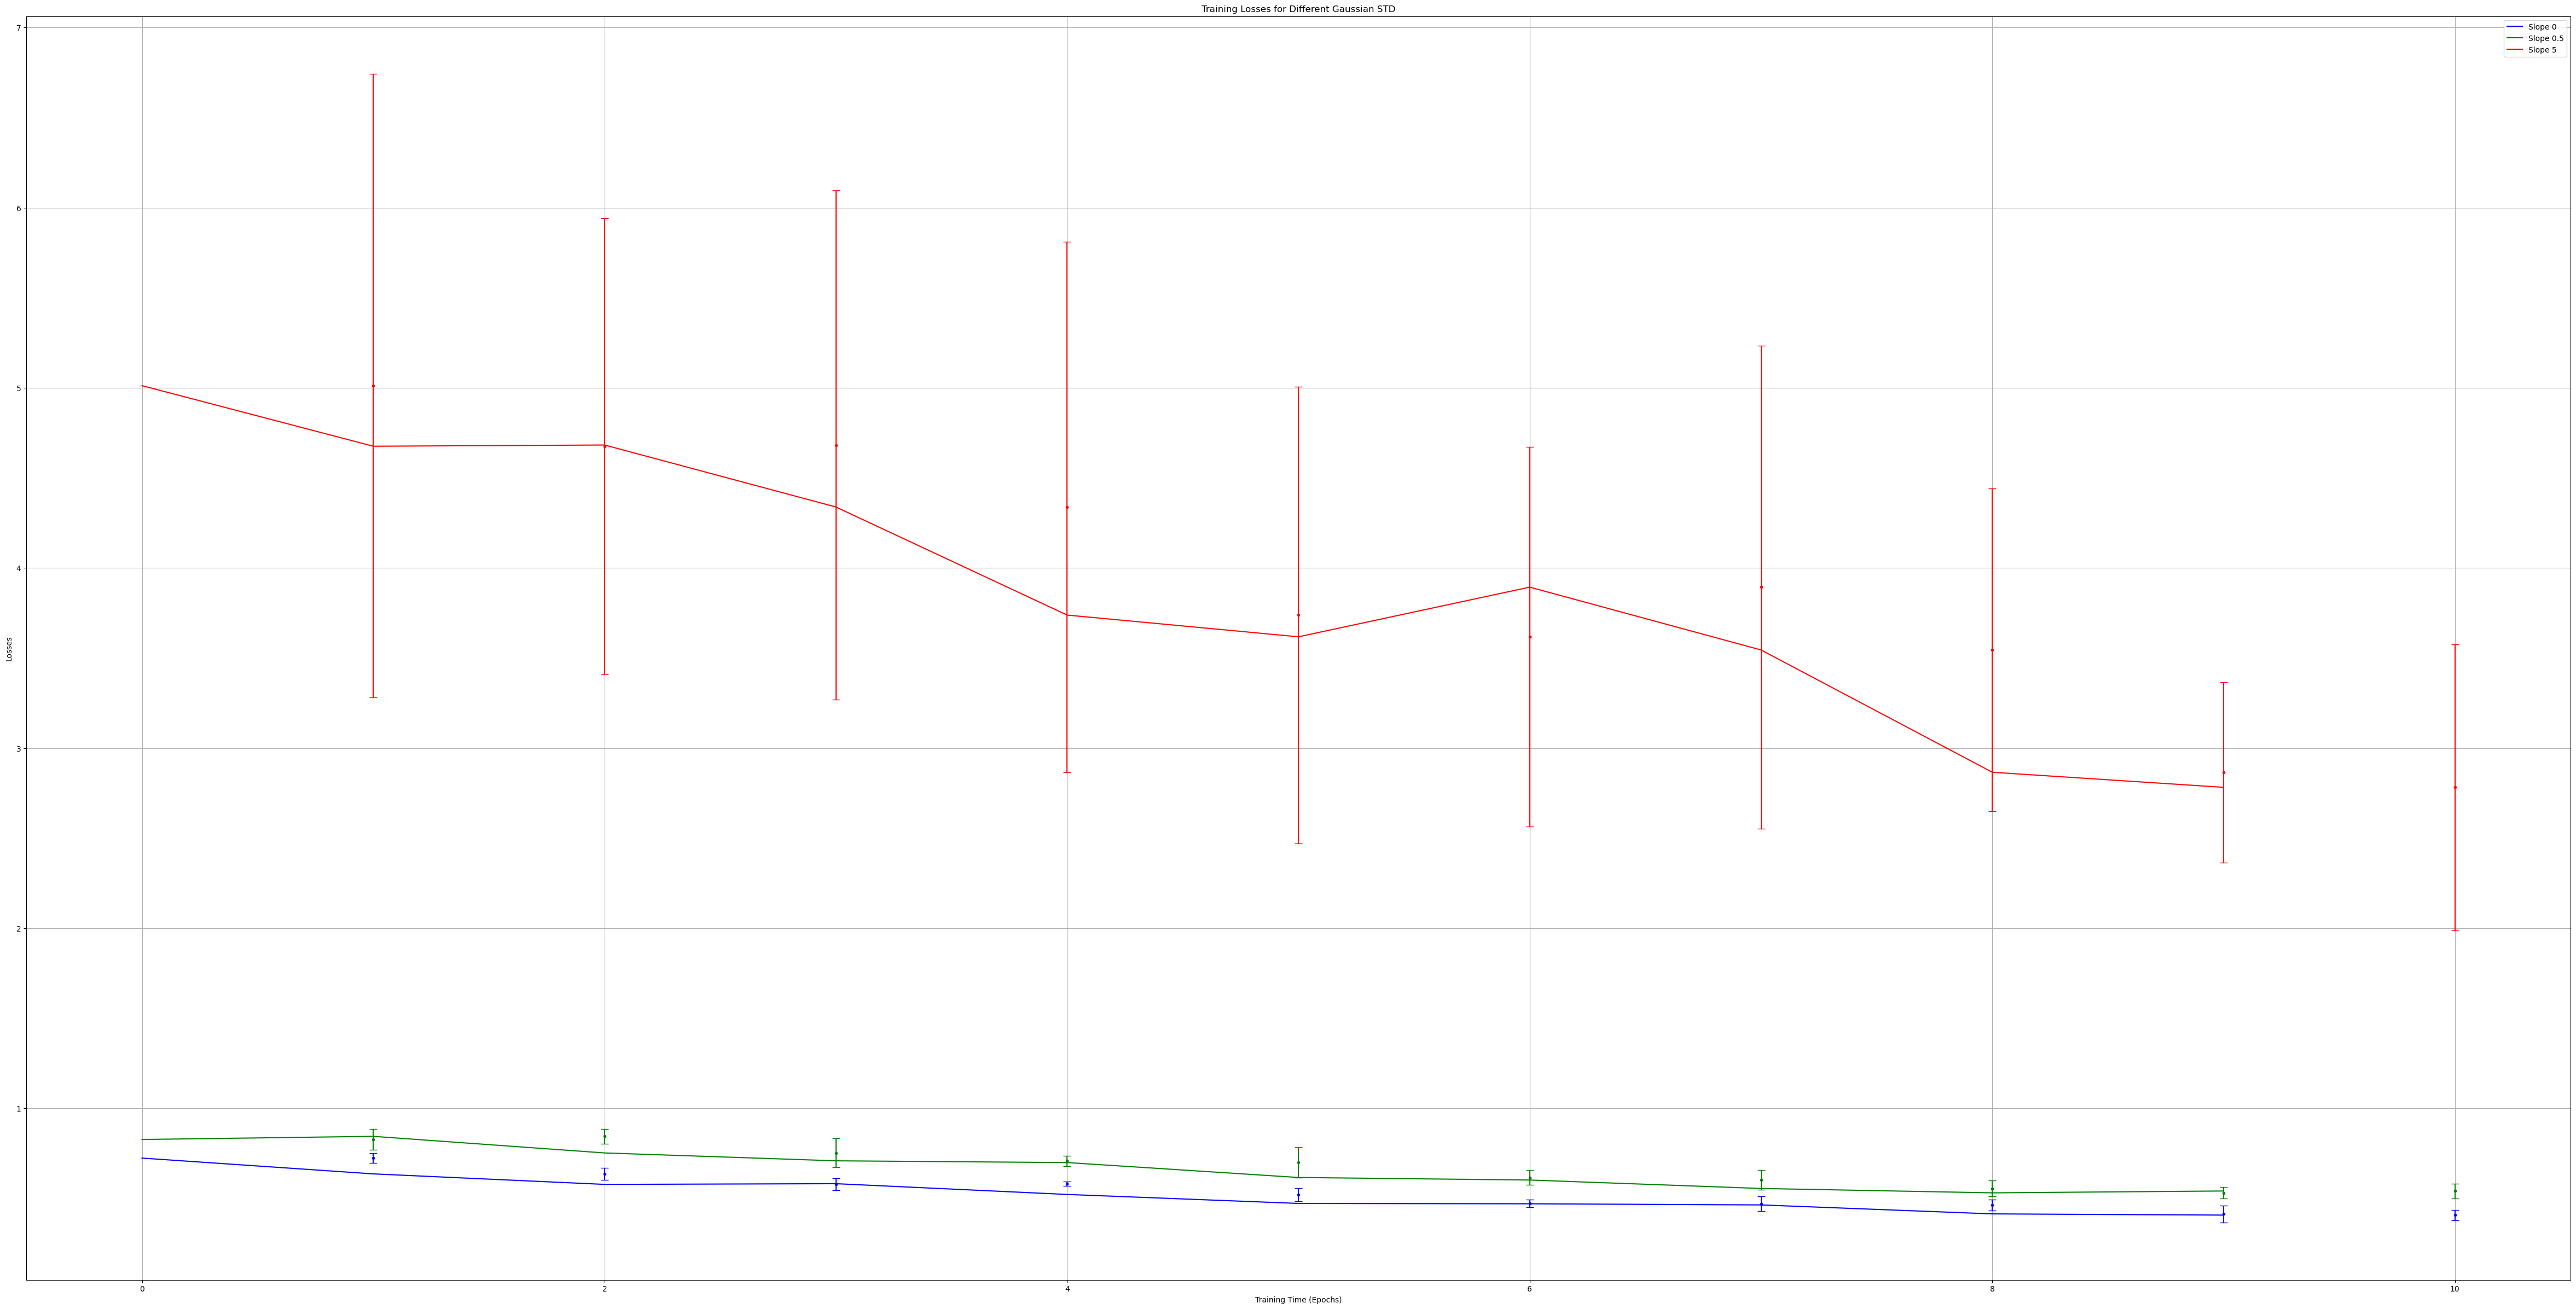

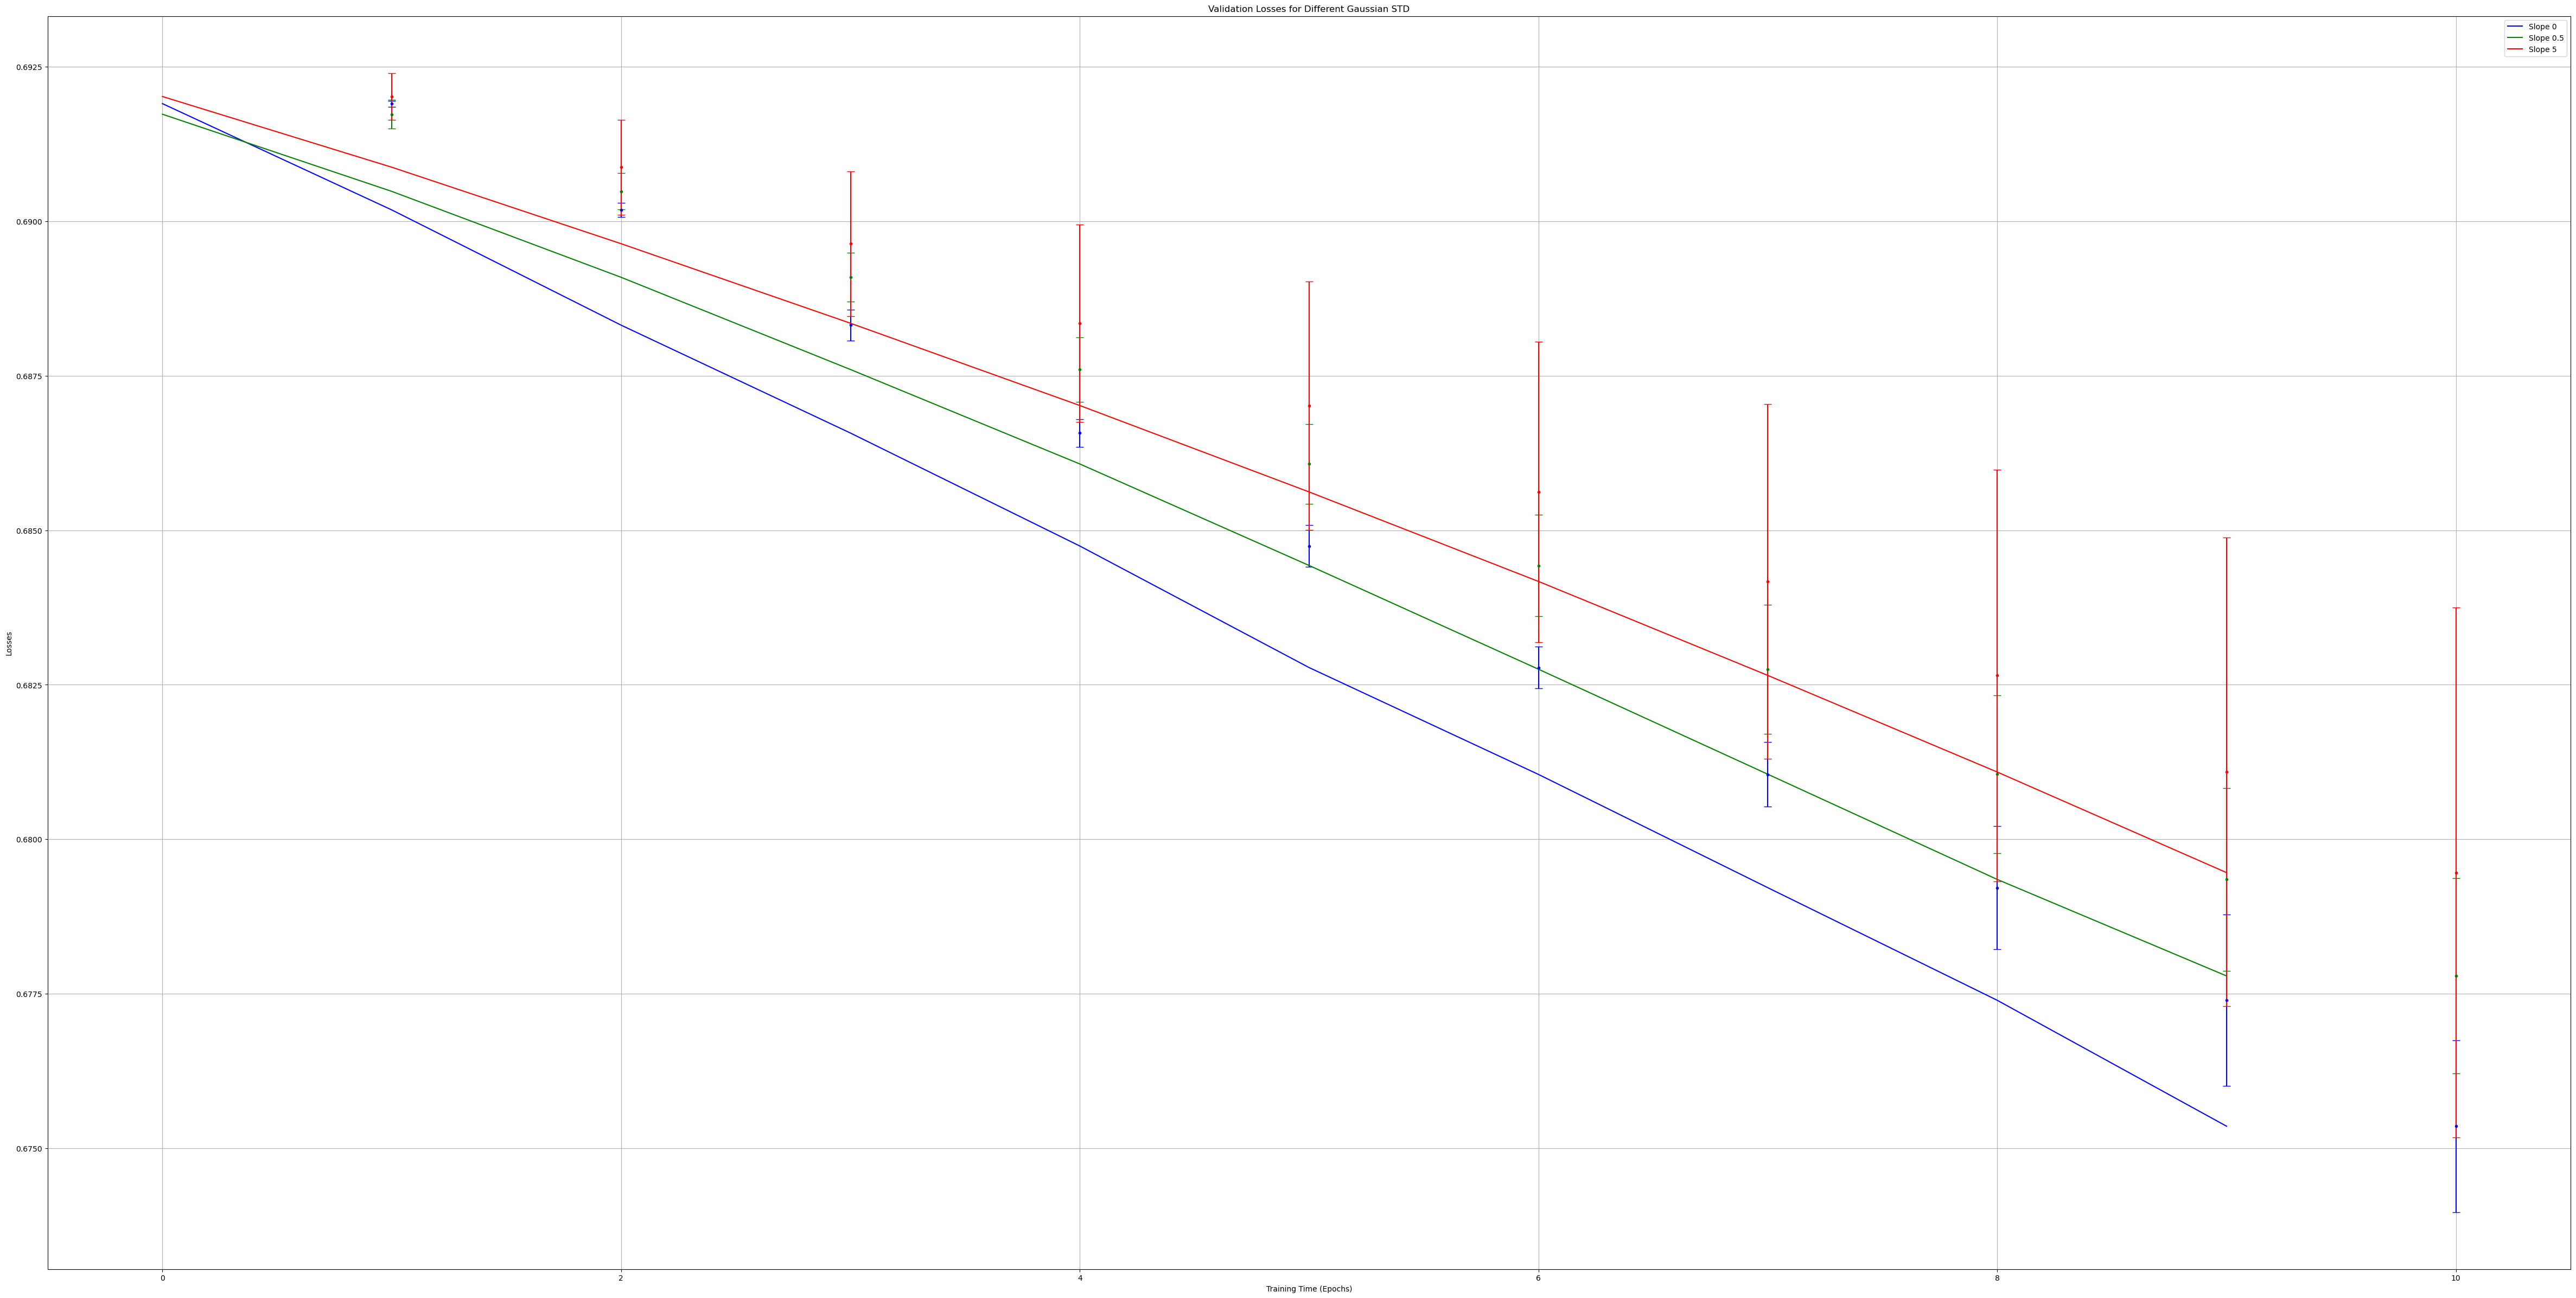

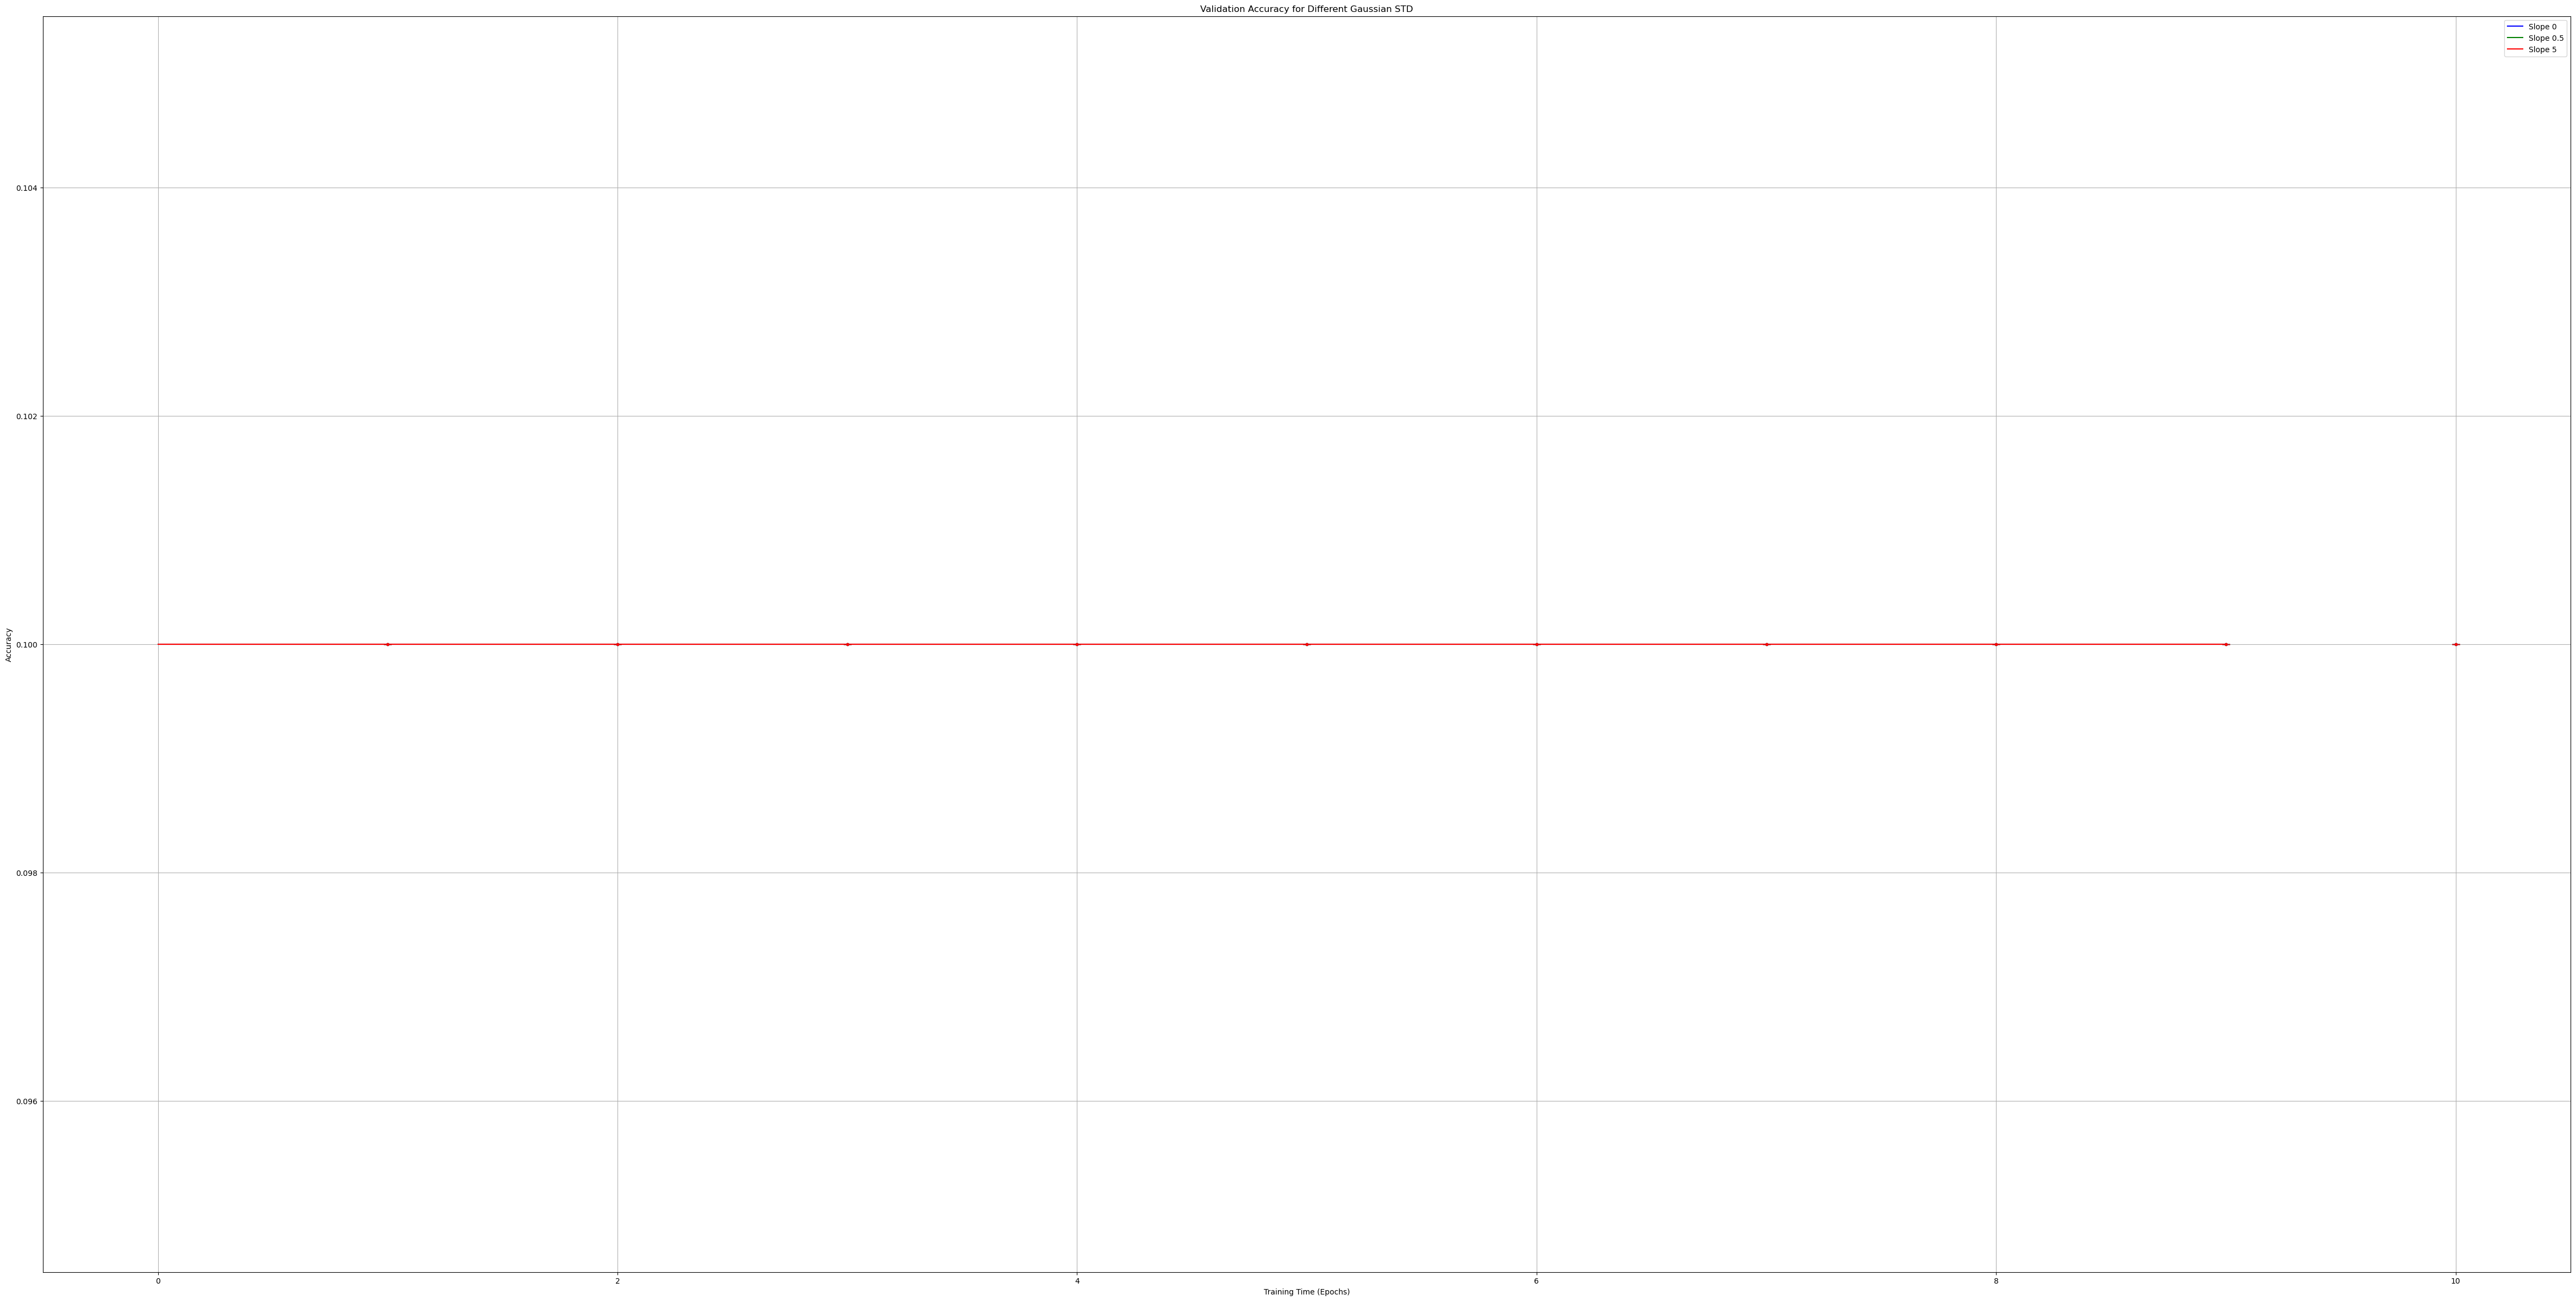

In [5]:
# In[4] : Main Training Loop
cor_dict.clear()
train_accuracies_dict.clear()
train_accuracies.clear()

train_loss_dict.clear()
train_losses.clear()

val_accuracies.clear()
val_accuracies_dict.clear()

val_losses.clear()
val_losses_dict.clear()

data = np.array(list(images_data.values()))
ep_path = f'../res/IN/{ep}'

for iteration in tqdm(range(num), desc='num_loop'):
    for std in noise_level_list:
        print("noise = ", std)
        
        model = build_cnn(
            input_shape=(130, 130, 3),
            slope_positive=custom_slope,
            noise_level=std,
            filter_size=16,
            num_classes=labels.shape[1]
        )

        # 2) Train with block-based splitting (first image in every 5 is test)
        trainedAcc_data, trainedLoss_data, validationAcc_data, validationLoss_data = train_model(
            model,
            data,      # entire dataset
            df,           # entire label set
            n_epochs=ep,      # renamed to match the train_model function
            batch_size=64,
            verbose=1
        )

        if std not in train_accuracies_dict:
            train_accuracies_dict[std] = []
        if std not in train_loss_dict:
            train_loss_dict[std] = []
        if std not in val_losses_dict:
            val_losses_dict[std] = []
        if std not in val_accuracies_dict:
            val_accuracies_dict[std] = []
        
        train_loss_dict[std].append(trainedLoss_data)
        train_accuracies_dict[std].append(trainedAcc_data)
        val_losses_dict[std].append(validationLoss_data)
        val_accuracies_dict[std].append(validationAcc_data)

        layer_name = f'least2_Dense_{custom_slope}_{std}'
        
        # if std not in cor_dict:
        #     cor_dict[std] = []
        # c_arr = compute_correlations(images_data, model, layer_name)
        # cor_dict[std].append(c_arr)


        trainedAcc_data = convert_to_serializable(train_accuracies_dict)
        trainedLoss_data = convert_to_serializable(train_loss_dict)
        validationAcc_data = convert_to_serializable(val_accuracies_dict)
        validationLoss_data = convert_to_serializable(val_losses_dict)


        save_json(trainedAcc_data, f'{ep_path}/trainedAcc_{ep}.json')
        save_json(trainedLoss_data, f'{ep_path}/trainedLoss_{ep}.json')
        save_json(validationAcc_data, f'{ep_path}/validationAcc_{ep}.json')
        save_json(validationLoss_data, f'{ep_path}/validationLoss_{ep}.json')


converted_dict = convert_to_serializable(cor_dict)
outputFilePath = f'../res/IN/{ep}/cor_output_{ep}_{iteration}.json'
save_json(converted_dict, outputFilePath)

plot_metrics_acc(train_accuracies_dict, ep, 'Training Accuracy for Different Gaussian STD', 'Training Accuracy')
plot_metrics_acc(train_loss_dict, ep, 'Training Losses for Different Gaussian STD', 'Losses')
plot_metrics_acc(val_losses_dict, ep, 'Validation Losses for Different Gaussian STD', 'Losses')
plot_metrics_acc(val_accuracies_dict, ep, 'Validation Accuracy for Different Gaussian STD', 'Accuracy')



## 3. Visualizing Correlational Matrix

/Users/tuomasier/Desktop/orginized_code_github/src/analysis.py:142: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hc.linkage(distance_matrix, method='average')


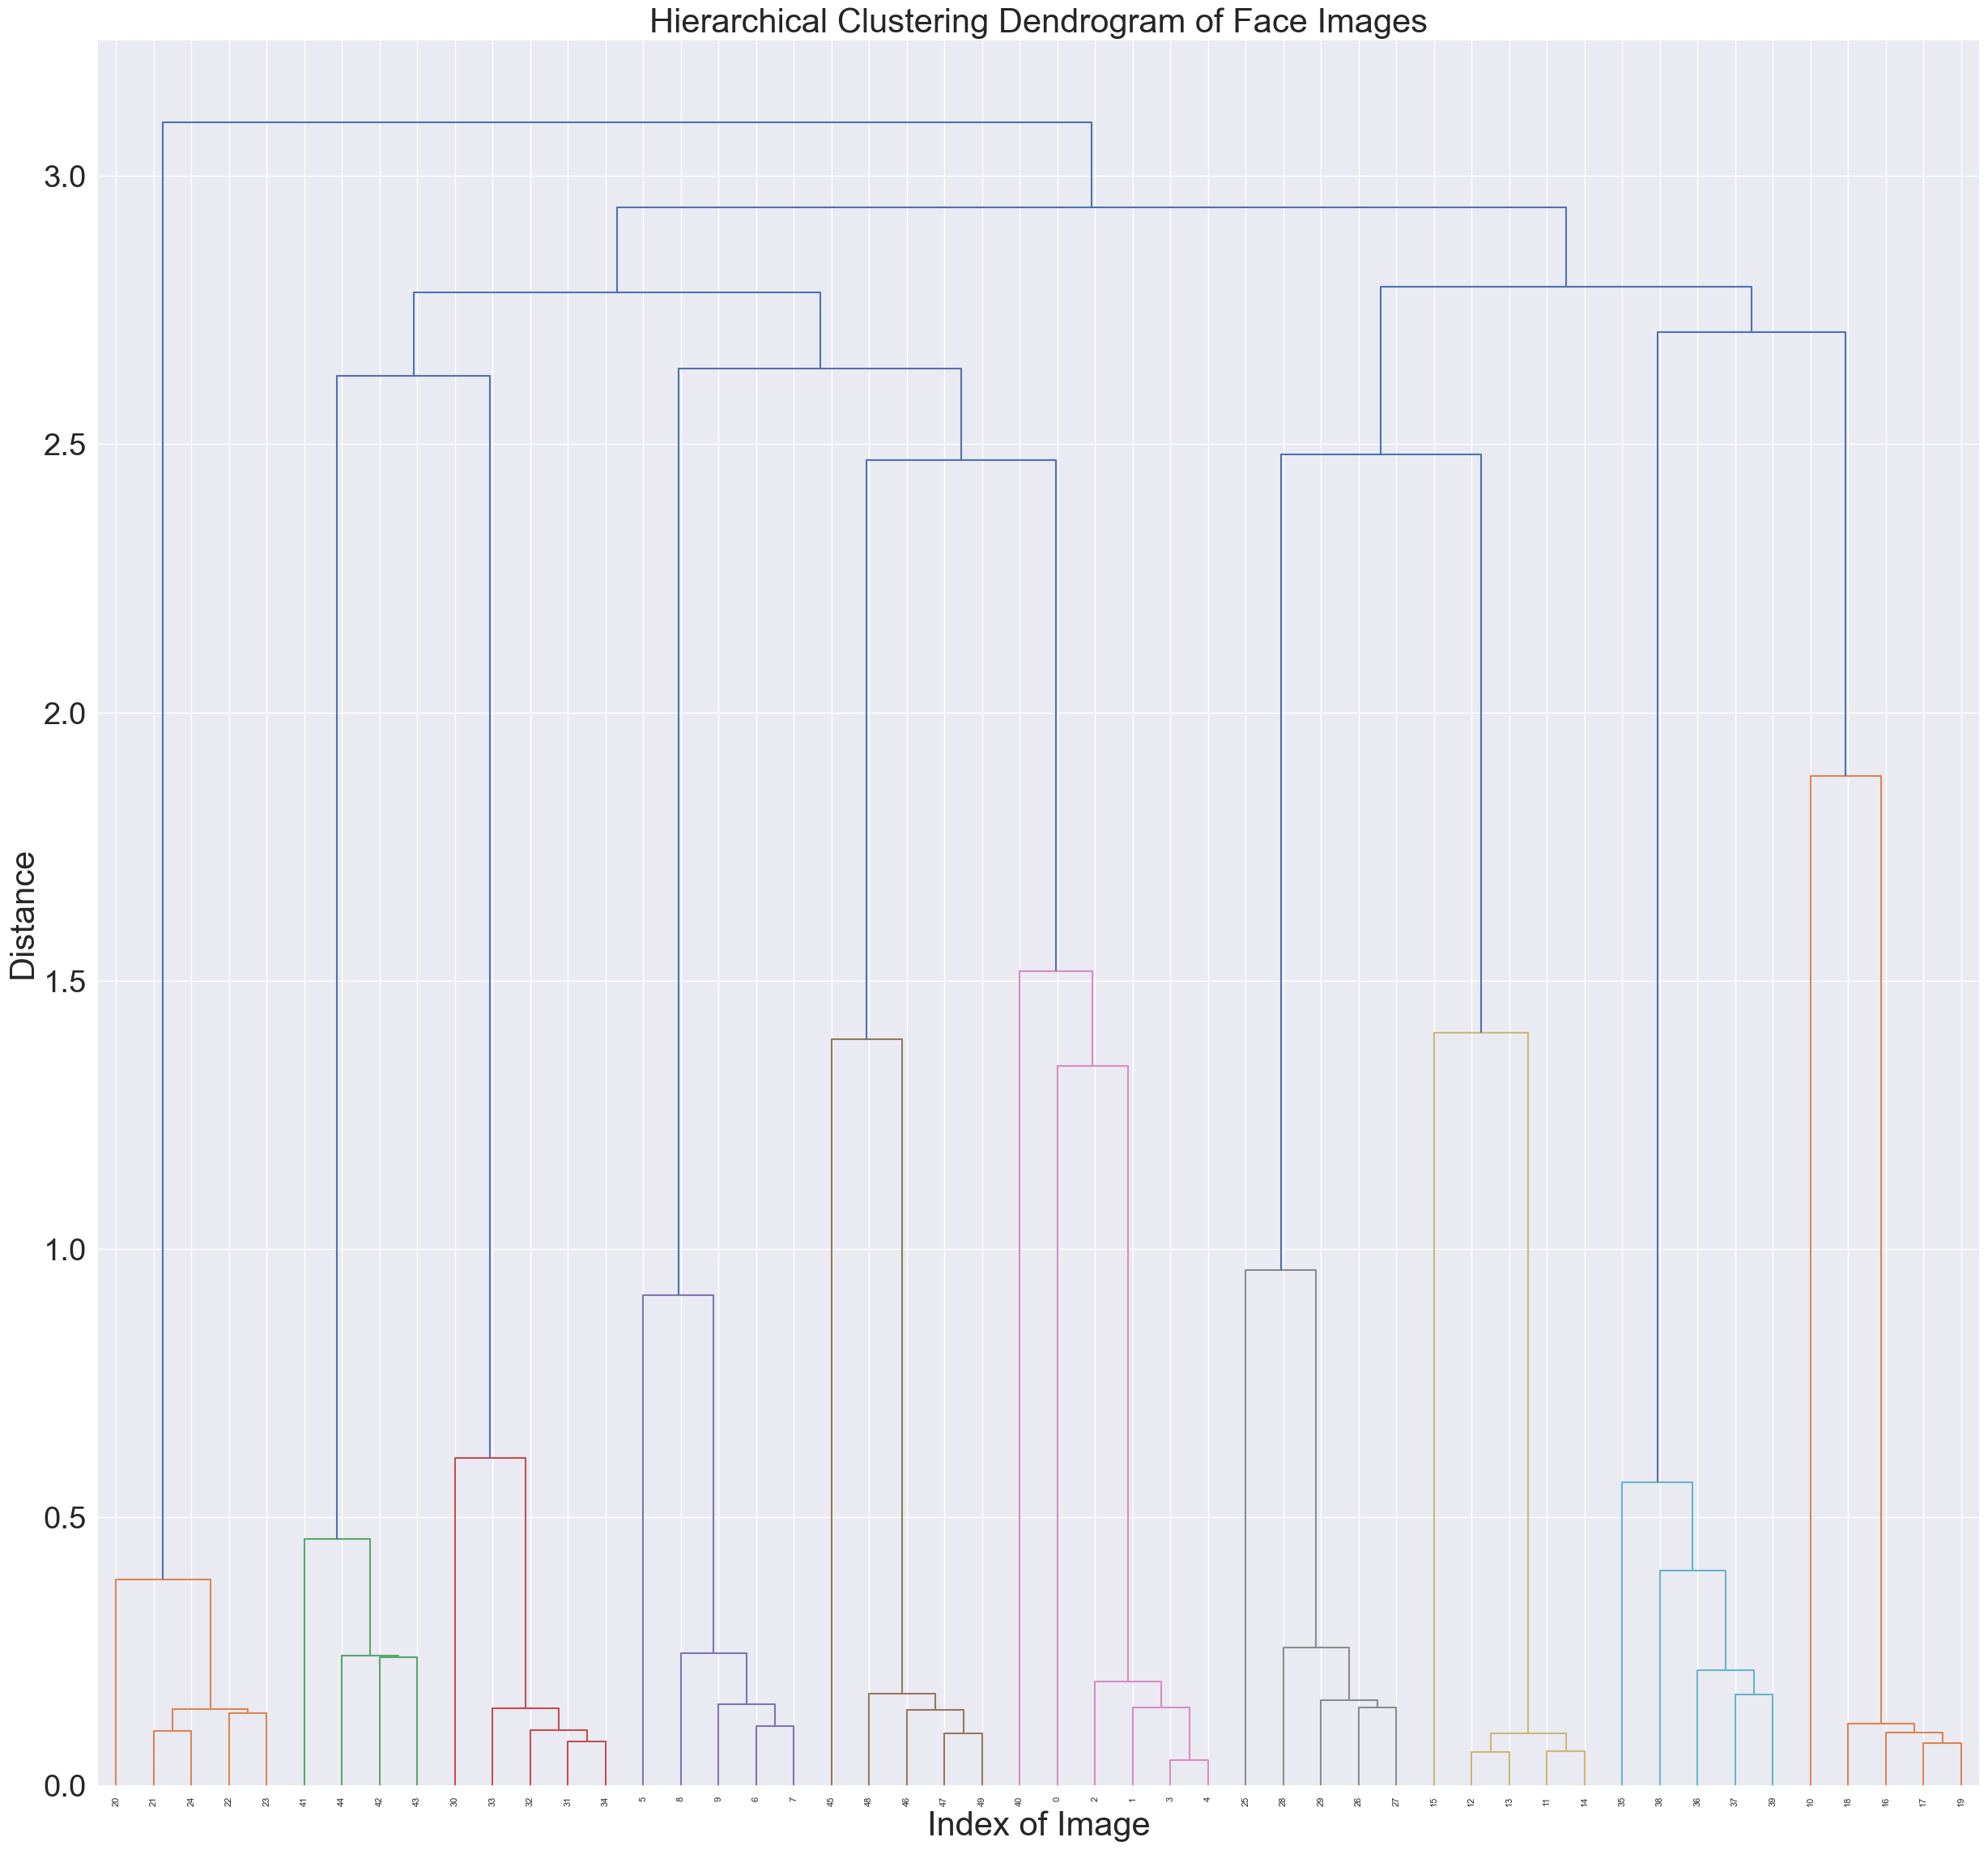

Mean within-person correlation = 0.9780210435390473
Mean out-of-person correlation = 0.023673532954417167


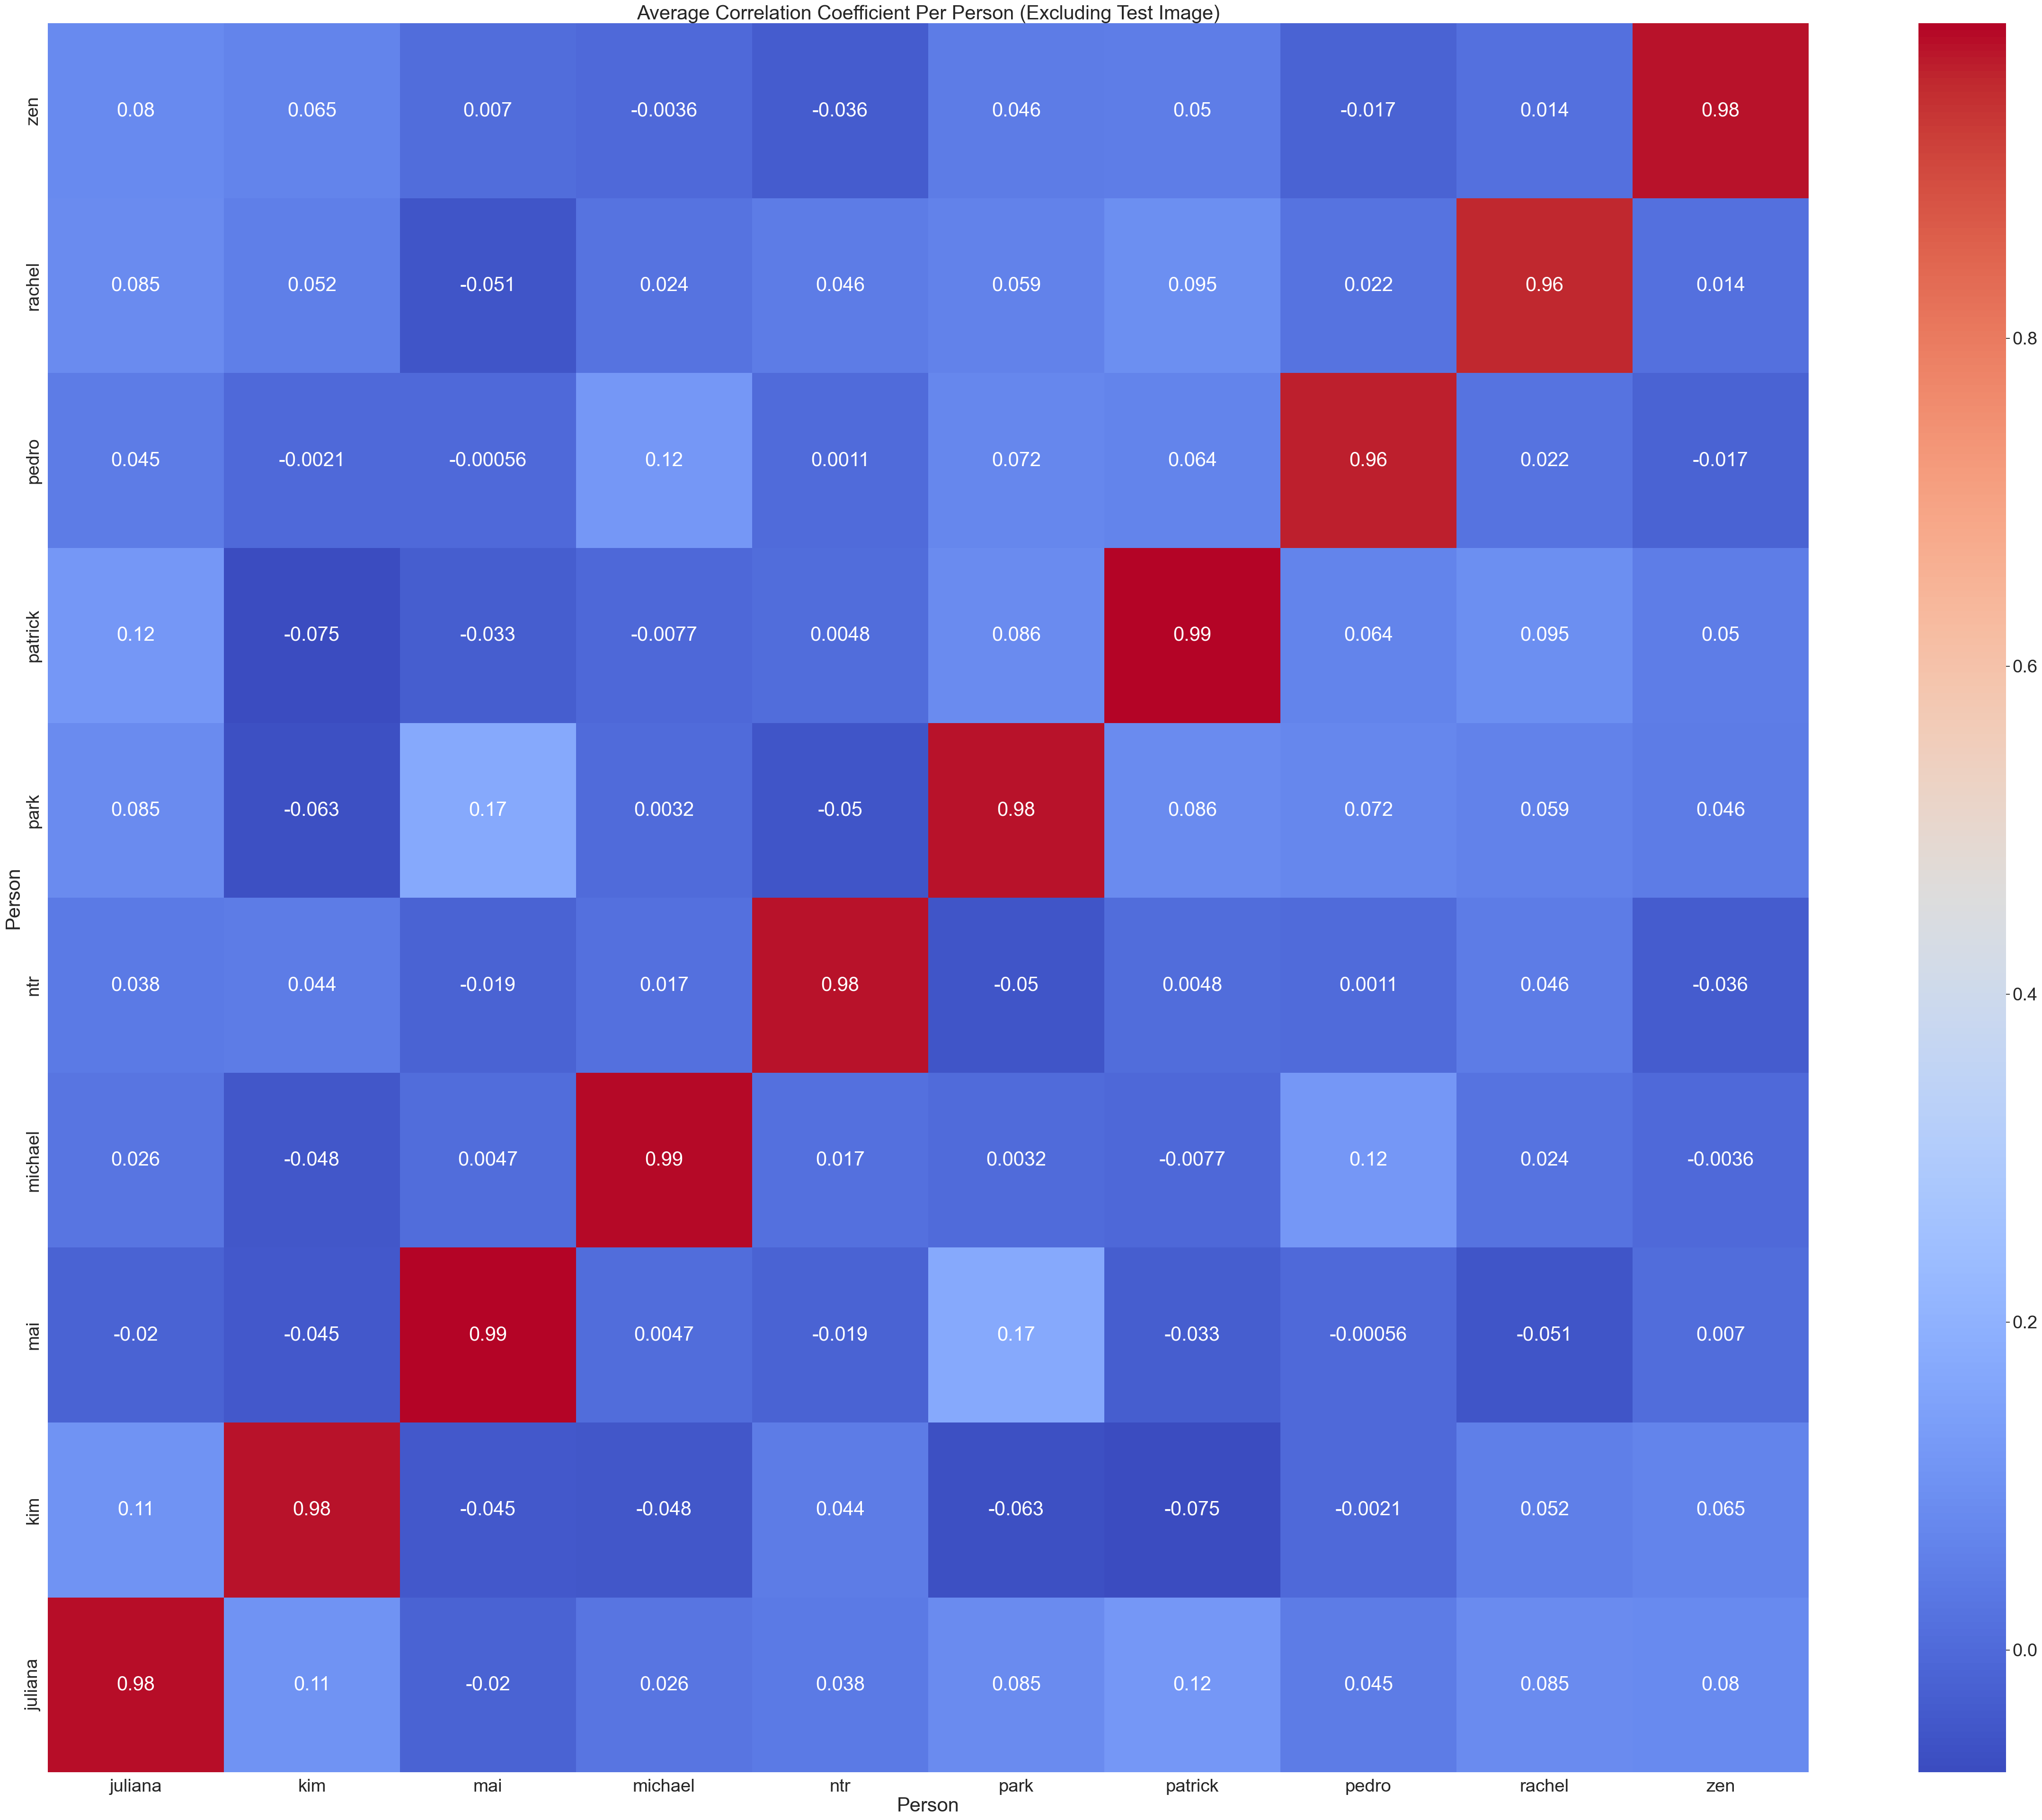

In [10]:

visualized_cor_mat(0, 10, num, personName, slope=0.05, noise=0) 

